In [1]:
import sys
sys.path.append('../../')

from car_iface import controller_model
from utils import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
'''
Set the MODE here to either use a Neural Model (FCN)
or the analytical equation.  Note the analytical equation
can only be used for simple motion dynamics.
'''
MODE = 0
MODE_DICT = {0: "Neural Model", 1: "Analytical Equation"}
print(f"Using {MODE_DICT[MODE]}")

Using Neural Model


In [3]:
'''
CAR_MODEL you set to either "simple" or "complex".
This dictates the internal model dynamics you will be using.
'''
CAR_MODEL = "complex"
ci = controller_model.Car_Interface(model = CAR_MODEL)

ci.set_gear(ci.FORWARD)

if (MODE_DICT[MODE] == "Simple Equation" and CAR_MODEL == "complex"):
    raise Exception("Invalid combination.")

## Stopping Distance Generation

Here we take advantage of the controller model we
developed using System ID.  Now instead of spending
excessive amounts of time manually controlling the car
we can easily generate data to work with.

For a basic implementation of this function follow the
below steps.  A model trained with this data will not
work in all cases, but it will generally.  If you would
like to learn why and come up with a more robust data
generation scheme see the braking_distance_extra ipynb
when it is released next lecture.

IMPORTANT NOTE: For this to work with the "complex"
car model you will have to first fill out one small
section around line 138 in controller_model.py. This
will allow your controller model to work with the non-linear 
SystemID shared during lecture.

In [4]:
'''
Basic Instructions:
1a.Select an initial velocity uniformly at random between 0 and 1. (see: np.random.random())
 b.Directly set the controller's velocity to this initial velocity.
 c.Zero the position of the controller.
2.Select a brake pedal amount, amt, uniformly at random between 0 and 1.
3a.Initialize a counter variable, t, to 0.
 b.While the controller's velocity is positive repeat the following steps.
 c.Apply the brakes at depression % amt for one time step.
 d.Increment t by the controller's dt time step.
 e.If t exceeds a time limit of 5 seconds, break out of this inner loop.
4.If the controller's velocity is 0 proceed, otherwise repeat steps 1 to 4.
5.The stopping distance is the position of the car, get this from the controller model.
6.Initialize inp as a list of length two, where the first element is the
  initial velocity, and the second element is the stopping distance.
7.Return amt, inp

What we are doing here is repeatedly trying random configurations of intial speed
and brake amount.  If we stop within the time limit then we have a valid data point.
The current position represents our stopping distance.

We take advantage of having a controller model in 3 ways.
1. Can run the simulations a lot faster.
2. Can directly set velocity (used in step 1b)
3. Don't have noise with measurements (helps a lot when velocity gets close to 0)

NOTE: this specific method of data generation produces a couple biases.  Consider
the following scenario.  The car is fairly far from the target brake point.  Further,
it is not moving very fast.  Here you attempt to precision brake, but you might find
the car stops too early Why might this type of data point not be captured by this
generation method?  If you see how to fix this feel free to do so.  If not next
lecture a supplementary notebook will be released detailing the few steps needed
to do so.
'''
def stopping_distance_gen():
    
    # CODE HERE
    init_v = np.random.random()
    ci.velocity = init_v
    ci.position = 0
    
    amt = np.random.random()
    
    t = 0
    while ci.velocity > 0:
        ci.apply_control(ci.BRAKE, amt)
        t += ci.dt
        if t > 5:
            break
            
    stopping_distance = ci.position
    inp = [init_v, stopping_distance]
    return amt, inp

In [5]:
'''
Displays a sample data point.  If this provides a reasonable 
output you probably did the previous part correctly.  
'''
amt, (initial_velocity, stopping_distance) = stopping_distance_gen()
print(f"A car moving at {initial_velocity * 100:.2f}% speed, applied {amt * 100:.2f}% brakes and stopped, after travelling {stopping_distance:.2f} distance units")

A car moving at 20.94% speed, applied 45.07% brakes and stopped, after travelling 0.10 distance units


## Analytical Solution for 'Simple' Car Model

IMPORTANT NOTE: When you have completed implementations of these two functions, paste their definitions into the corresponding locations (under the matching function headers) in braking_distance/bd_api.py.  This is what the simulator will actually interact with.

In [6]:
'''
Write the analytical solution for the theoretical stopping distance.
The equation is presented in the lecture slides (Slides 9-13)

Some helpful reminders:
    The linear model assumes: accel = c_1 * p_accel + c_2 * p_brake + c_3 * vel + c_4
    c_1 = ci.accelerator_weight
    c_2 = ci.brake_weight
    c_3 = -ci.friction_constant
    c_4 = ci.rolling_bias
    (Where ci is the car interface you initialized above)

Implemenation Instructions:
1. Initialize x, f, and v0 from available information
2. Check if the expression in Slide 13 would evaluate infinity, if so return float('inf')
3. Otherwise return the stopping distance as calculated in Slide 3.

NOTE: the stopping distance will be infinite when the brake amount is not enough to 
overcome the rolling bias.

The only discrepancy between this and the actual stopping distance
arises from the discretized nature of the simulation.  This is
a precise calculation otherwise.

IMPORTANT: After implementing this sucessfully paste the function body in 
the corresponding and marked location in braking_distance/bd_api.py (line 80)
'''
def simple_analytical_sd(initial_velocity, amt):
    
    #CODE HERE
    x = ci.brake_weight * amt + ci.rolling_bias
    f = ci.friction_constant
    v0 = initial_velocity
    
    if (amt < ci.rolling_bias):
        return float('inf')
    else:
        return 1/f * (v0 + x/f * np.log(1-f*v0/x))

'''
Function takes as input the initial velocity and desired stopping distance.
Then using binary search returns an estimate within the specified tolerance
of the actual required brake amount.

Parameters:
inp: (initial velocity, desired stopping distance)
tol: estimate tolerance 
min_amt: minumum possible value of the required brake amount (initially 0)
max_amt: maximum possible value of the required brake amount (initially 1)


Implemenation Instructions
1.Initialize mid_amt as the midway point between min_amt and max_amt.
2.If the length of the min max interval is less than twice the tolerance,
  then mid_amt is a valid estimate (+/- the the tolerance of the actual)
3a.Calculate the analytical stopping distance with the given initial velocity,
   and current estimate (mid_amt).
 b.Update min_amt and max_amt accordingly to narrow the search space and recurse.
   (NOTE: careful, if the stopping distance is too high is the mid_amt too high or low?)
   
IMPORTANT: After implementing this sucessefully paste the function body in the 
corresponding and marked location in braking_distance/bd_api.py (roughly line 90)
'''
def simple_analytical_approx(inp, tol = 1e-5, min_amt = 0, max_amt = 1):
    
    #CODE HERE
    mid_amt = (min_amt + max_amt) / 2
    if (max_amt - min_amt < 2 * tol):
        return mid_amt
    
    asd = simple_analytical_sd(inp[0], mid_amt)
    if (asd > inp[1]):
        return simple_analytical_approx(inp, tol, min_amt + 0.1, max_amt)
    else:
        return simple_analytical_approx(inp, tol, min_amt, max_amt - 0.1)

In [7]:
'''
Demonstrate the performance of the Analytical Equation Estimate
with a few examples.  (The estimate is the "Closed Form Brake Amount").
The simulated result and the closed form brake amount should be very close.
The discrepancy is largest in extreme value cases where the discretization
has a significant effect.
'''
if (MODE == 1):
    for i in range(3):
            amt, (initial_velocity, stopping_distance) = stopping_distance_gen()
            pred = simple_analytical_approx((initial_velocity, stopping_distance))
            print(f"Car moving at {initial_velocity * 100:.2f}%; Target Stopping Distance {stopping_distance:.2f} distance units")
            print(f"Simulation Brake Amount: {amt*100:.2f}%; Closed Form Brake Amount {pred*100:.2f}%")
            print()

## FCN Training and Evaluation

In [8]:
'''
Initialize FCN.

You will need to supply additional parameters to the
initializer function. See utils/nn.py for documentation.
See demos/week3/Nonlinear_SystemID for example usage.

Hint 1: There are two additional parameters you need to specify
Hint 2:  What are the inputs for this FCN?  What is the ouput?
What are the reasonable possible outputs?

NOTE: If this is your first time running this block it will 
randomly initialize a set of weights.  Afterwards by default,
this will load weights you trained earlier.  If you would like
to force the model to reinitialize weights, provide a third
additional argument retrain = True. (see utils/nn.py for more)
'''
if (MODE == 0):
    model = nn.fcn(model_name = "../../braking_distance/" + CAR_MODEL + "_bd", num_inputs = 2, out_range = (0,1))#CODE HERE)

In [9]:
'''
Generate 1000 inputs and targets and train for 200 epochs on this
generated data.  (Note you can run this blck a few times to train
further).

Implementation Instructions:
1.Initialize two empty lists, inputs and targets.
2a.Get a brake amount and and two dimensional input by calling
   stopping_distance_gen()
 b.Append the input to the inputs list, and the brake amount to
   the targets list.
 c.Repeat 2a and 2b 1000 times.
3.Use the model.train method to train with this data for 200 epochs.
  (See nn.py for function information)
'''
if (MODE == 0):
    
    #CODE HERE
    inputs = []
    outputs = []
    for i in range(0, 1000):
        amount, two_inp = stopping_distance_gen()
        inputs.append(two_inp)
        outputs.append(amount)
    model.train(input_data = inputs, targets = outputs, num_epochs = 200)


EPOCH 1 0.032208
EPOCH 41 0.010067
EPOCH 81 0.009634
EPOCH 121 0.009633
EPOCH 161 0.009343


In [10]:
'''
Demonstrate the performance of the FCN brake amount estimator
with a few examples.
'''
if (MODE == 0):
    for i in range(3):
        '''
        Generate an example scenario complete with an initial velocity,
        target stopping distance, and necessary brake amount.
        
        Then run your model on the appropriate input and record it's
        predicted brake amount.
        
        Finally fill in the variable names you used in the blanks to output
        the input, target, and output.
        
        Ideally the model ouput should be fairly close to the brake amount.
        '''

        #CODE HERE
        amt, inp = stopping_distance_gen()
        pba = model.predict(inp)

        print(f"INIT VEL: {inp[0]:.3f} TARG SD: {inp[1]:.3f} BRK AMT: {amt:.3f} MODEL OUT:{pba:.3f} ")

INIT VEL: 0.453 TARG SD: 0.287 BRK AMT: 0.549 MODEL OUT:0.629 
INIT VEL: 0.222 TARG SD: 0.072 BRK AMT: 0.919 MODEL OUT:0.964 
INIT VEL: 0.641 TARG SD: 0.522 BRK AMT: 0.546 MODEL OUT:0.613 


WITHIN 0.1 217/300 times
MEDIAN ERROR 0.0633


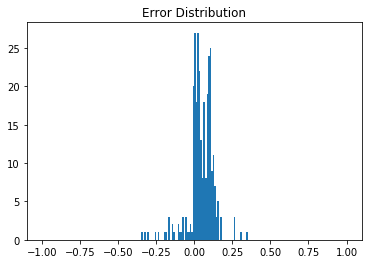

In [11]:
'''
Empirically evaluate the model for it's performance.
Present two stats in the end:
1) The proportion of the time that the estimate is
   within a certain tolerance (here 0.1)
2) The median estimation error.
'''
TEST = 300
correct = 0
tol = 0.1
errors = []
for i in range(TEST):
    print(f"TESTING {i + 1}/{TEST}", end = "\r")
    amt, inp = stopping_distance_gen()

    if (MODE == 0):
        out = model.predict(inp)
    elif (MODE == 1):
        out = simple_analytical_approx(inp, tol = 1e-5)

    if (abs(out - amt) < tol):
        correct += 1
    errors.append(out - amt)
print(f"WITHIN {tol} {correct}/{TEST} times")
print(f"MEDIAN ERROR {np.median(np.abs(errors)):.4f}")

plt.title("Error Distribution")
plt.hist(errors, bins = 200, range = (-1, 1))
plt.show()

## Model Usage

Now you're ready to test out your algorithm!  Run the simulator in braking distance mode (command below) to begin.  Drive around to make sure you remember the controls.

python simulator.py --mode braking_distance

To run with complex internal model run:

python simulator.py --mode braking_distance --car_model complex

## Target Brake Point Marking

Now drive up to one of the red stop lines in the simulator, braking nicely in front of the line.  Click 'm' this will record the position and direction in which you stopped in as a keypoint target.  Repeat this process at a few other stop lines.  (You could do other locations as well, but this is the most practical). 

If you accidentally add erroneous keypoints you can delete them individually by running keypoints.py. (Or delete all of them by trashing the keypoint_locations.json).  Note, either of these files are in the braking_distance folder.

## Precision Braking

To apply precision braking approach a brake point while driving.  If a target brake point is in your heading, you should notice the option to hold 'b' appear in the terminal window.  This indicates that you may begin precision braking.  Hold 'b' to precision brake.  Release one you have stopped moving.  

A graph will come up detailing how much you depressed the brake pedal as you approached the target brake point.  The reason we brake a varying amount over time is because we are replanning every timestep.  This prevents error from building up in our model, and naturally adjusts the car's behavior as appropriate.

## Evaluation

You will be evaluated on whether or not you successfully brake, somewhat smoothly, roughly at your target brake point.  You shouldn't overshoot the brake point or stop too early either.  This should work for both simple and complex models.